<a href="https://colab.research.google.com/github/Yagwar/Sociadisticas/blob/master/Preprocessing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

import seaborn as sns
sns.set(color_codes=True)

import matplotlib as mpl
mpl.style.use('seaborn-talk')
# %matplotlib inline


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd
from scipy.stats import chi2_contingency

import unicodedata
import nltk
# nltk.download('punkt')
import string
import re

from IPython.display import YouTubeVideo
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

from scipy.linalg import diagsvd
import functools


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = 'gdrive/My Drive/Freelancer/alc_bog_19/'

Mounted at /content/gdrive


In [0]:
### Functions
def process(text):
  """
  Preprocesamiento de texto, ajustado a los tuits
  """
  # todo en minúsculas
  text=str(text).lower()
  # remove diacritics # ATENCION!!!! Esto incluye la "ñ"
  text = ''.join(c for c in unicodedata.normalize('NFD', text)
                 if unicodedata.category(c) != 'Mn')
  # Remove links (usually photos)
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)

  # Remove next line mark
  text = re.sub("\n",' ',text)

  # remove hastags mark
#   text = re.sub(r'#([^\s]+)', ' ', text)#r'\1', text)

  # Replaces "@user" with "atUser"
#   text = re.sub('@[^\s]+',' ',text)

  # Replaces repetitions 
  text = re.sub(r"(\!)\1+", ' ', text) # multiple exclamations
  text = re.sub(r"(\?)\1+", ' ', text) # multiple questions

  # Removes unicode strings like "\u002c" and "x96"
  text = re.sub(r'(\\u[0-9A-Fa-f]+)',r' ', text)       
  text = re.sub(r'[^\x00-\x7f]',r' ',text)
  
  # Removes integers
#   text = ''.join([i for i in text if not i.isdigit()])
  # Removes emoticons from text
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', ' ', text)

  return text

###
def plot_uni_var(df_dats,column_name):
  """
  identificar el tipo de variable y hacer un gráfico univariado.
  """
  if (df_dats[column_name].dtype=="int64")or(df_dats[column_name].dtype=="float64"):
    plt.figure(figsize=(16,9))
    sns.distplot(df_dats[column_name][df_dats[column_name].notna()])##(df_dats[column_name])
    plt.title(column_name)
    plt.show()

  if df_dats[column_name].dtype=="bool":
    plt.figure(figsize=(16,9))
    df_dats[column_name].value_counts().plot(kind="bar")
    plt.title(column_name)
    plt.show()

  if df_dats[column_name].dtype=="object":
    plt.figure(figsize=(16,9))
    df_dats[column_name].value_counts()[:20].plot(kind="bar")
    plt.title(column_name)
    plt.show()

# Rotación VarimaX
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

def tabl_cont_lex(features_mat,sparse_mat_ocurrs, lexic_index):
  """
  Tabla de contingencia léxica. Toma una matriz dispersa y los valores de las variables categóricas y retorna un data frame de n cantidad de palabras por m valores de one-hot encoding de las variales categóricas
  features_mat: tabla de las variables categóriccas 
  sparse_mat_ocurrs: sparse matrix de las ocurrencias  de palabras
  """
  lexic_columns=[str(feature)+"_"+str(feat_val)
                 for feature in list(features_mat.columns)
                 for feat_val in list(set(features_mat[feature]))
                ]
  feature_value=[[feature,feat_val]for feature in list(features_mat.columns)for feat_val in list(set(features_mat[feature]))]
  lexic_array=np.array([[sum(sparse_mat_ocurrs[:,n_palabra].toarray().reshape(1,-1)[0][features_mat[dat_pair[0]]==dat_pair[1]]) 
                         for dat_pair in feature_value] 
                        for n_palabra in range(len(lexic_index))])#50)])#

#   lexic_array=np.array([[sum(sparse_mat_ocurrs[:,n_palabra].toarray().reshape(1,-1)[0][features_mat[feature]==feat_val])
#                          for feature in list(features_mat.columns)
#                          for feat_val in list(set(features_mat[feature]))]
#                         for n_palabra in range(len(lexic_index))])
  lexic_df=pd.DataFrame(lexic_array, 
                        index=lexic_index,
                        columns=lexic_columns)
  return lexic_df

###
def Matrix_mult(*args):
    """An internal method to multiply matrices."""
    return functools.reduce(np.dot, args)

np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
pd.set_option('display.precision', 5)
pd.set_option('display.max_columns', 25)




In [0]:
cuentas=["ClaudiaLopez","carlosfgalan","angelamrobledo","MiguelUribeT","angelagarzonc",
         "luchogarzon","hollmanmorris","MAndreaNieto","CelioNievesH","jerojasrodrigue",
         "LuisErnestoGL"]

# Explore data
Perform [Exploratory Data Analysis](https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python)

In [0]:
# data=pd.read_csv(drive_path+"sample_1.csv", index_col=0)
# data=pd.read_csv(drive_path+"candidatos_alcaldia.csv", index_col=0)
# data=pd.concat([pd.read_csv(drive_path+"candidatos_alcaldia_2.csv", index_col=0),
#                 pd.read_csv(drive_path+"candidatos_alcaldia.csv", index_col=0)])


In [0]:
dict_names=[#'tweet_id',
            'date_tweet',
            'user_id',
            'user_name',
            'user_location',
            'user_verified',
            'user_followers_count',
            'user_friends_count',
            'user_favourites_count',
            'user_statuses_count',
            'user_created_at',
            'is_retweet',
            'tw_text',
            'is_quote_status',
            'is_reply',
            'user_id_replyed',
            'user_name_replyed',
            'tweet_id_replyed',
            'quote_count',
            'reply_count',
            'retweet_count',
            'retweeted',
            'tweet_url']
data=pd.read_csv(drive_path+"extracted_dict.csv",names=dict_names,index_col=0)


In [0]:
data.sample(20)

,date_tweet,user_id,user_name,user_location,user_verified,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,user_created_at,is_retweet,tw_text,is_quote_status,is_reply,user_id_replyed,user_name_replyed,tweet_id_replyed,quote_count,reply_count,retweet_count,retweeted,tweet_url
1165151430338125829,Sat Aug 24 06:38:43 +0000 2019,436997151,AngelaPosada4,Colombia,False,189,272,10721,25483,Wed Dec 14 20:55:21 +0000 2011,True,Acompáñame a ver esta triste historia...\n@Cla...,False,False,NaN,NaN,NaN,0,0,0,False,https://twitter.com/AngelaPosada4/status/11651...
1166542008644714497,Wed Aug 28 02:44:22 +0000 2019,2758581327,hugoospina55,NaN,False,3174,657,5,2934,Mon Sep 01 20:46:14 +0000 2014,False,@ActivistaCo @Uber_Col @rugeparticipa @LuisErn...,False,True,1.04795e+18,ActivistaCo,1.16417e+18,0,0,0,False,https://twitter.com/hugoospina55/status/116654...
1161680843934449664,Wed Aug 14 16:47:50 +0000 2019,952004062576304129,EstherSauru,NaN,False,4871,3767,174227,39002,Sat Jan 13 02:27:10 +0000 2018,False,@ClaudiaLopez ¿Quién tiene las peores asesores...,False,True,1.37909e+08,ClaudiaLopez,1.16168e+18,0,0,0,False,https://twitter.com/EstherSauru/status/1161680...
1161803778590461952,Thu Aug 15 00:56:20 +0000 2019,211524431,gialmartin,Bogotá,False,74,207,724,1627,Wed Nov 03 14:10:35 +0000 2010,False,"@AlvaroUribeVel @MiguelUribeT Mentiras, como l...",False,True,6.10972e+07,AlvaroUribeVel,1.16180e+18,0,0,0,False,https://twitter.com/gialmartin/status/11618037...
1169410916472905728,Thu Sep 05 00:44:23 +0000 2019,709363531066507265,alvaropincor,NaN,False,54,160,4110,3851,Mon Mar 14 13:00:19 +0000 2016,True,Nuestro candidato @MiguelUribeT asiste a la f...,False,False,NaN,NaN,NaN,0,0,0,False,https://twitter.com/alvaropincor/status/116941...
1168860546466287616,Tue Sep 03 12:17:25 +0000 2019,223489916,javinem99,Bogotá-Cund-U.S-Boyacá-Vichada,False,262,965,63,11065,Mon Dec 06 14:53:46 +0000 2010,True,Ayer ex funcionario de la administración de @p...,True,False,NaN,NaN,NaN,0,0,0,False,https://twitter.com/javinem99/status/116886054...
1169549863954112512,Thu Sep 05 09:56:31 +0000 2019,1050918072142495745,NestorG07012429,"Soacha, Colombia",False,463,1312,11419,8850,Sat Oct 13 01:16:08 +0000 2018,True,@ArnulfoBetancur @ClaudiaLopez Ahora es que no...,False,False,NaN,NaN,NaN,0,0,0,False,https://twitter.com/NestorG07012429/status/116...
1162506040447029250,Fri Aug 16 23:26:53 +0000 2019,444840752,GracyEnciso,NaN,False,38,102,7510,10480,Fri Dec 23 18:09:59 +0000 2011,False,"La irregularidad es que viven en contravía, se...",True,False,NaN,NaN,NaN,0,0,0,False,https://twitter.com/GracyEnciso/status/1162506...
1172239959245361152,Thu Sep 12 20:06:00 +0000 2019,3354310233,jonathan_sole,"Bogotá, D.C., Colombia",False,190,600,14164,16000,Thu Jul 02 03:00:34 +0000 2015,True,@camilovitamina @HOLLMANMORRIS @petrogustavo @...,False,False,NaN,NaN,NaN,0,0,0,False,https://twitter.com/jonathan_sole/status/11722...
1170015419811450880,Fri Sep 06 16:46:28 +0000 2019,407297075,elianadelgador,NaN,False,2280,1289,145733,53671,Mon Nov 07 22:14:38 +0000 2011,True,Dicen que en la encuesta de mañana @ClaudiaLop...,False,False,NaN,NaN,NaN,0,0,0,False,https://twitter.com/elianadelgador/status/1170...


In [0]:
data.columns

Index(['date_tweet', 'user_id', 'user_name', 'user_location', 'user_verified',
       'user_followers_count', 'user_friends_count', 'user_favourites_count',
       'user_statuses_count', 'user_created_at', 'is_retweet', 'tw_text',
       'is_quote_status', 'is_reply', 'user_id_replyed', 'user_name_replyed',
       'tweet_id_replyed', 'quote_count', 'reply_count', 'retweet_count',
       'retweeted', 'tweet_url'],
      dtype='object')

In [0]:
data.shape

(1026050, 22)

## Ajustar los tipos de datos
* Fechas


In [0]:
data["date_tweet"]=pd.to_datetime(data['date_tweet'], utc=True)#.tz_convert('US/Eastern')
data["user_created_at"]=pd.to_datetime(data['user_created_at'], utc=True)#.tz_convert('US/Eastern')

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1026050 entries, 1161444297704726528 to 1174299062805389313
Data columns (total 22 columns):
date_tweet               1026050 non-null datetime64[ns, UTC]
user_id                  1026050 non-null int64
user_name                1026050 non-null object
user_location            576173 non-null object
user_verified            1026050 non-null bool
user_followers_count     1026050 non-null int64
user_friends_count       1026050 non-null int64
user_favourites_count    1026050 non-null int64
user_statuses_count      1026050 non-null int64
user_created_at          1026050 non-null datetime64[ns, UTC]
is_retweet               1026050 non-null bool
tw_text                  1026050 non-null object
is_quote_status          1026050 non-null bool
is_reply                 1026050 non-null bool
user_id_replyed          303602 non-null float64
user_name_replyed        303602 non-null object
tweet_id_replyed         290845 non-null float64
quote_count  

In [0]:
data.describe()

,user_id,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,user_id_replyed,tweet_id_replyed,quote_count,reply_count,retweet_count
count,1.02605e+06,1.02605e+06,1.02605e+06,1.02605e+06,1.02605e+06,3.03602e+05,2.90845e+05,1026050.0,1026050.0,1026050.0
mean,3.09303e+17,4.57987e+03,1.23087e+03,2.55803e+04,3.99209e+04,1.33770e+17,1.16755e+18,0.0,0.0,0.0
std,4.61909e+17,9.62971e+04,2.38162e+03,5.18455e+04,7.27935e+04,3.42025e+17,1.43928e+16,0.0,0.0,0.0
min,7.08843e+05,0.00000e+00,0.00000e+00,0.00000e+00,1.00000e+00,2.03900e+03,2.74904e+17,0.0,0.0,0.0
25%,2.70427e+08,1.08000e+02,2.07000e+02,1.59000e+03,3.29300e+03,1.19763e+08,1.16489e+18,0.0,0.0,0.0
50%,1.34311e+09,3.64000e+02,5.72000e+02,8.25100e+03,1.32330e+04,1.63342e+08,1.16854e+18,0.0,0.0,0.0
75%,8.46916e+17,1.14500e+03,1.42600e+03,2.76600e+04,4.44470e+04,1.35764e+09,1.17137e+18,0.0,0.0,0.0
max,1.17415e+18,8.33557e+06,3.69203e+05,1.56635e+06,1.26668e+06,1.17414e+18,1.17430e+18,0.0,0.0,0.0


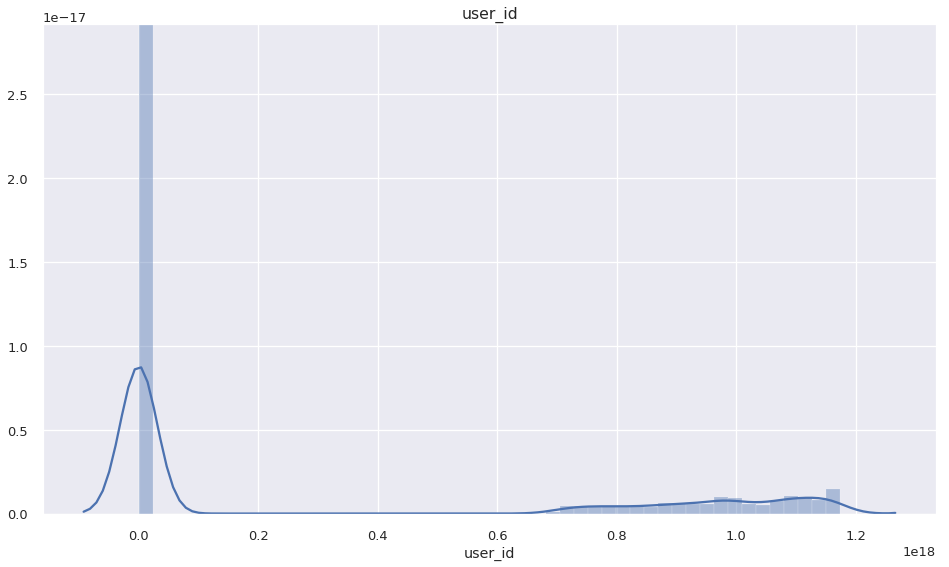

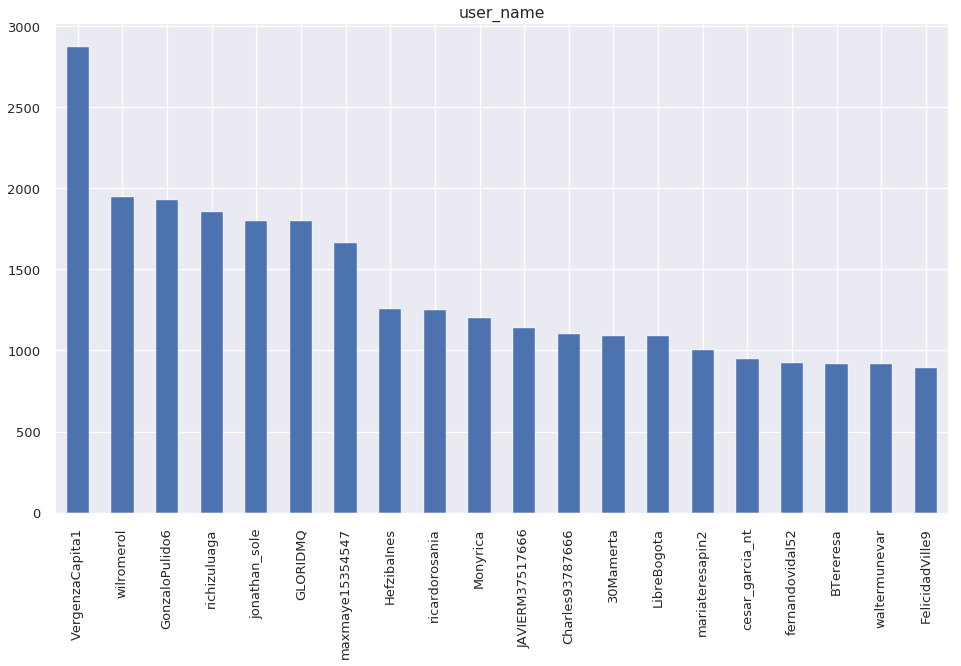

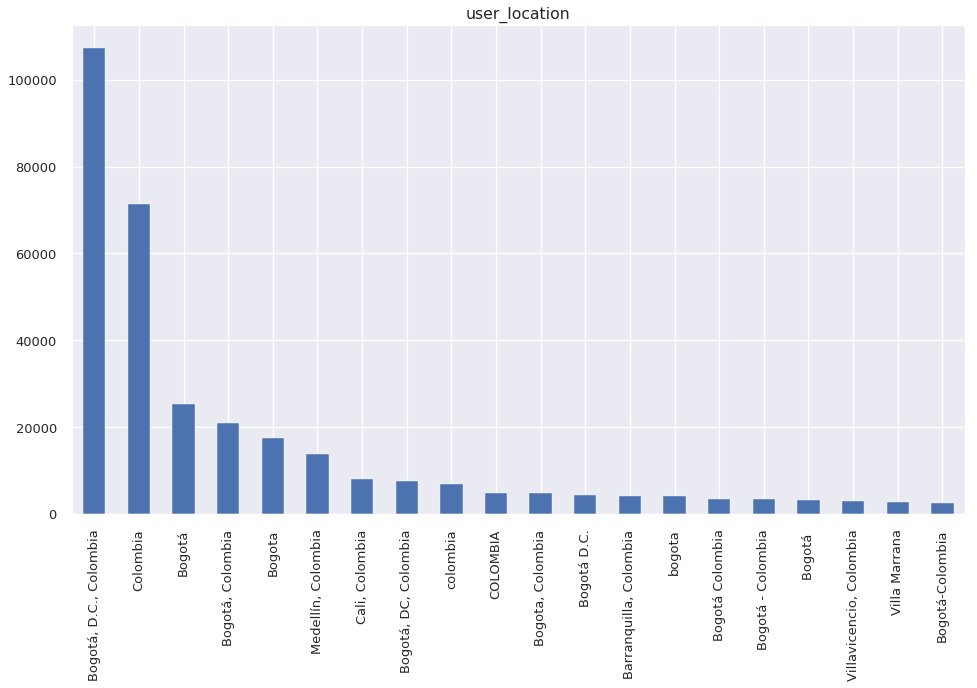

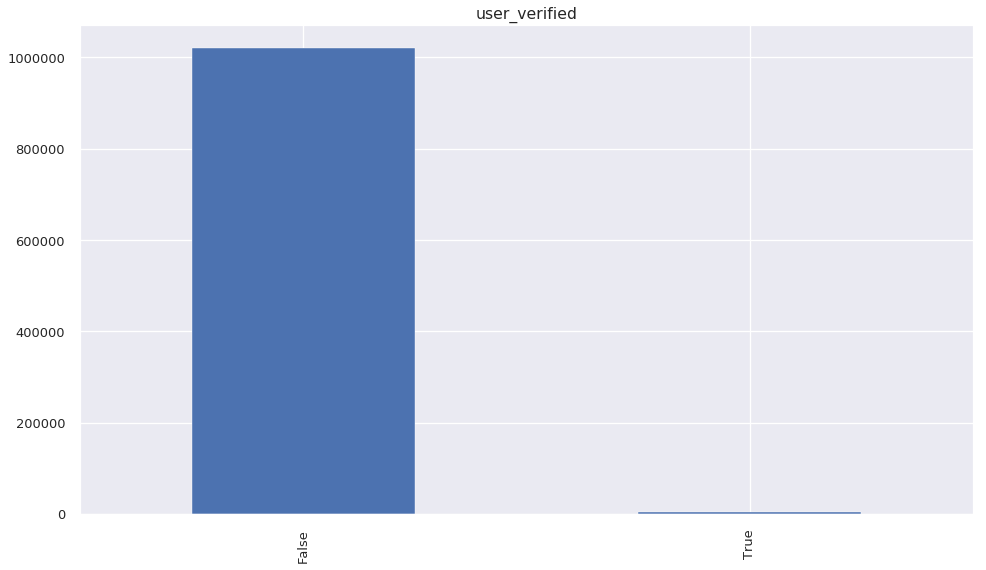

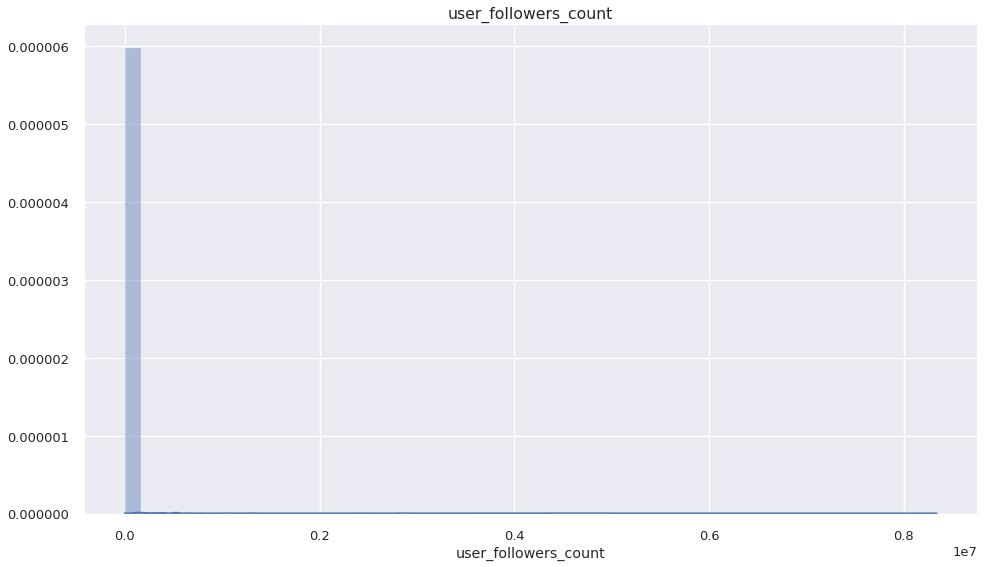

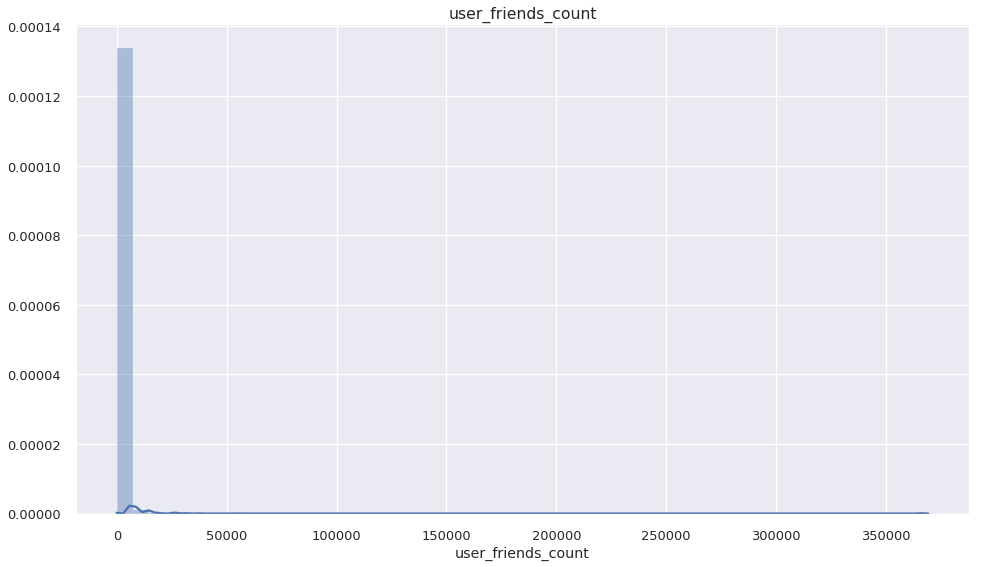

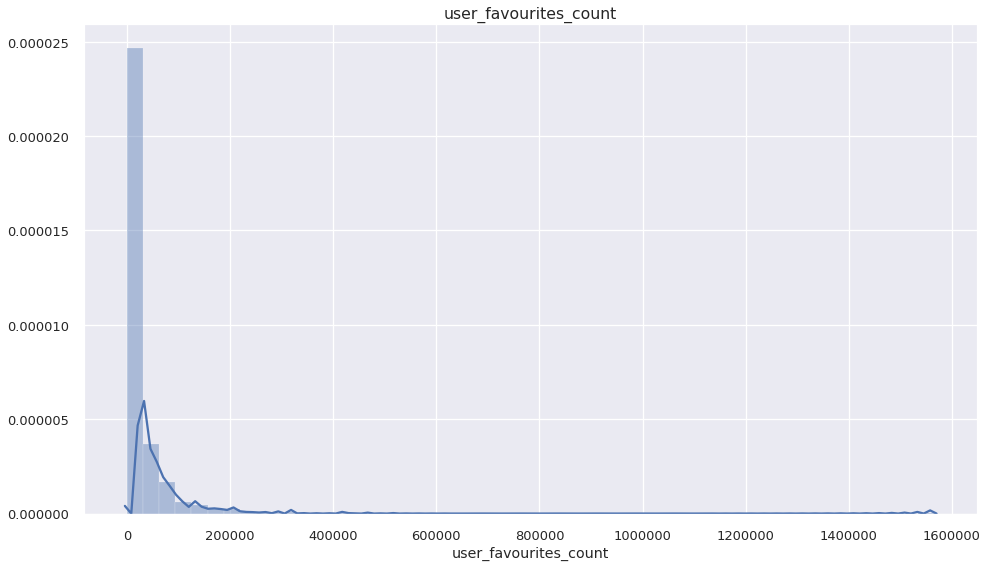

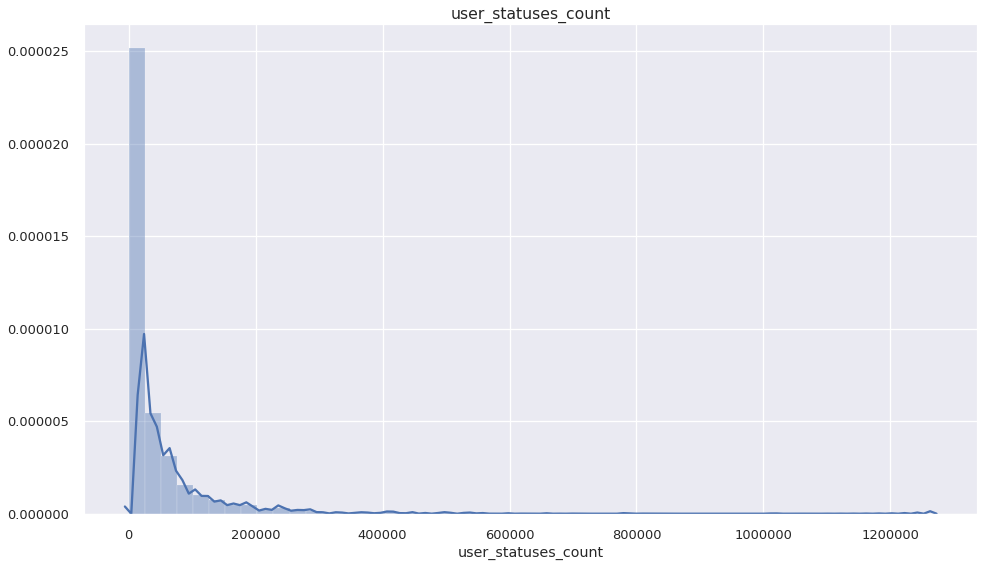

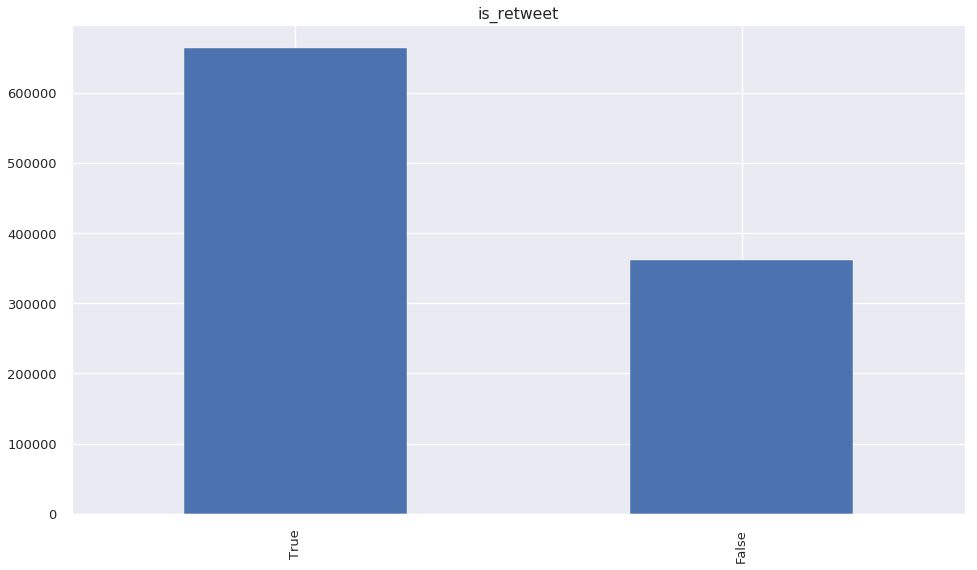

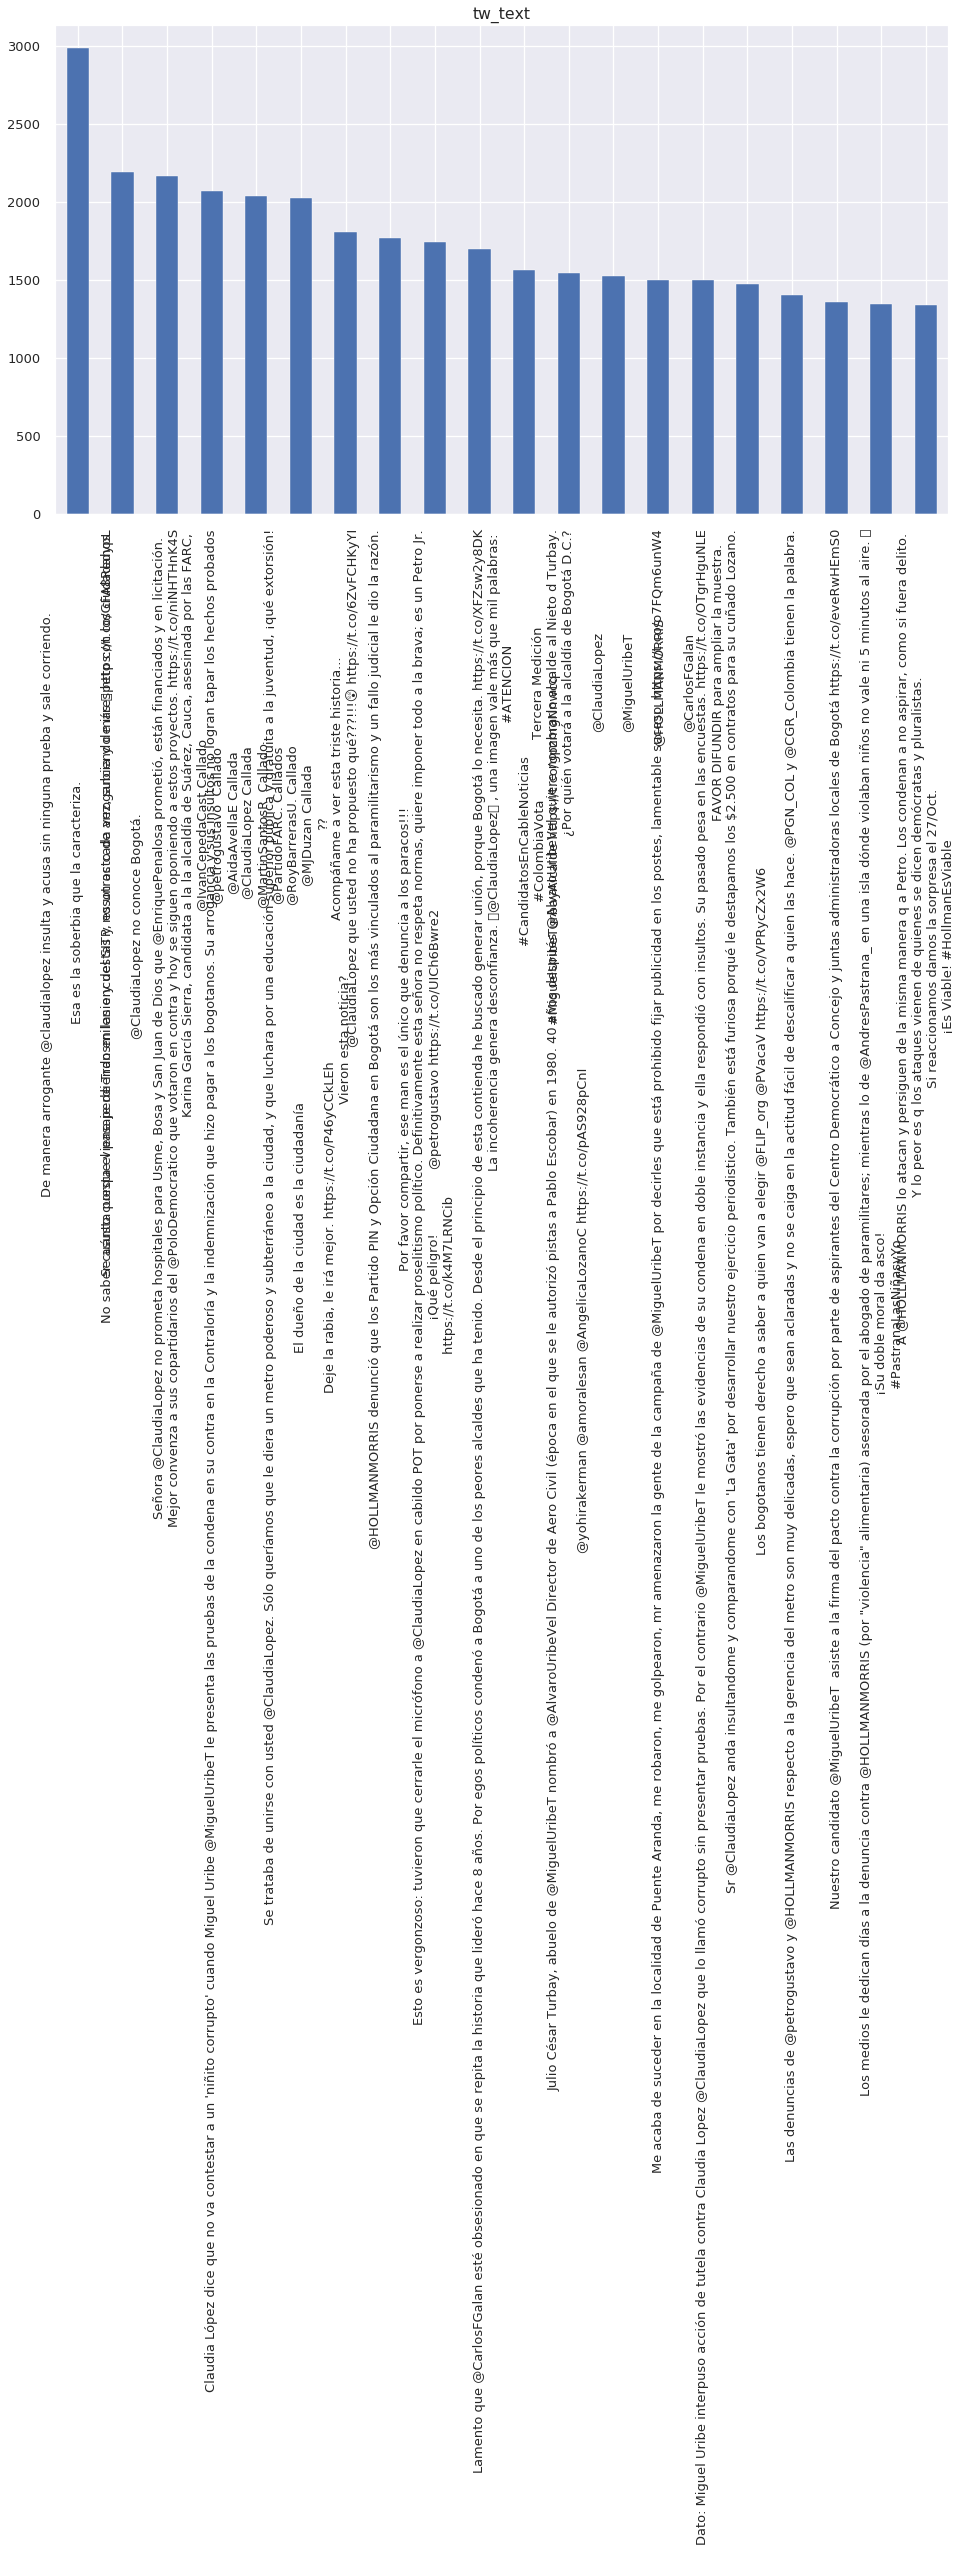

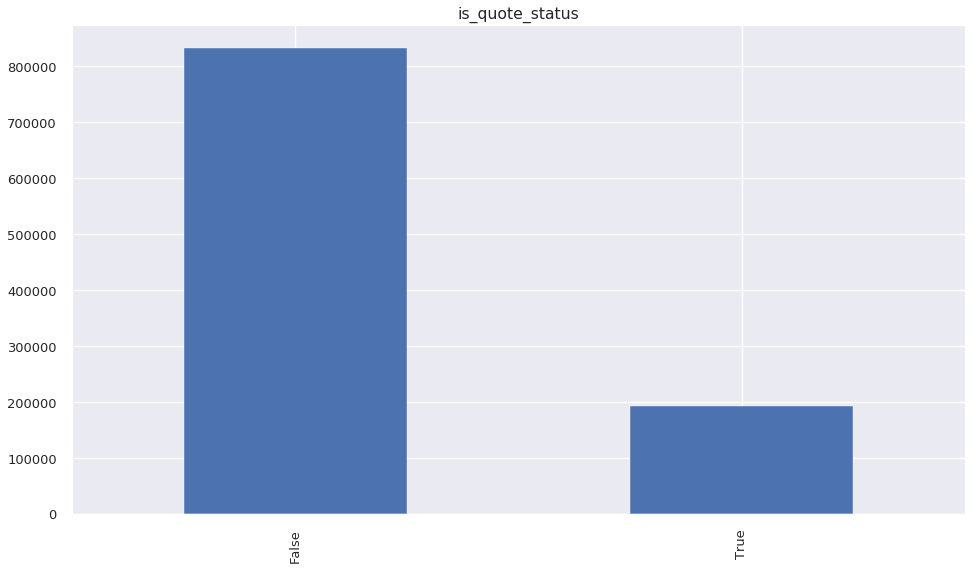

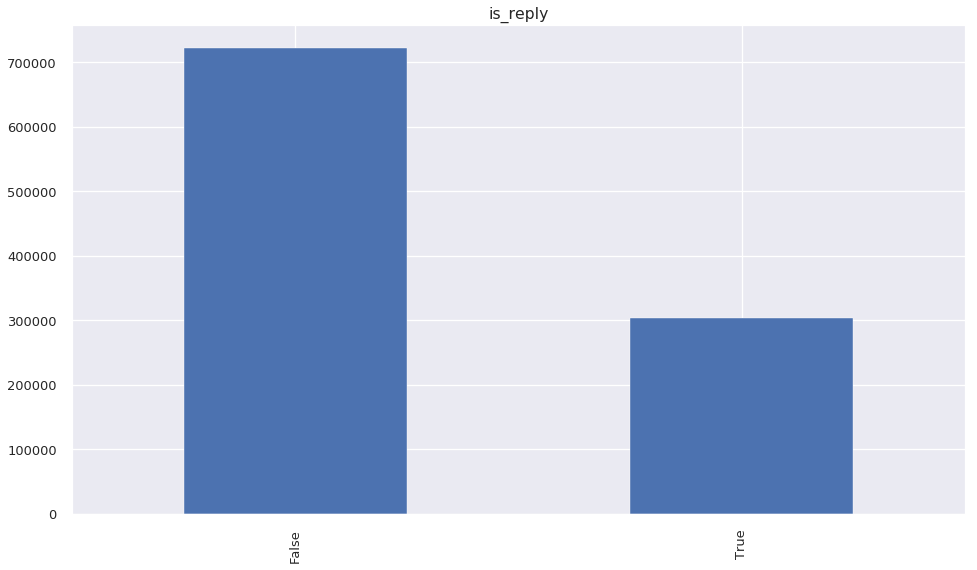

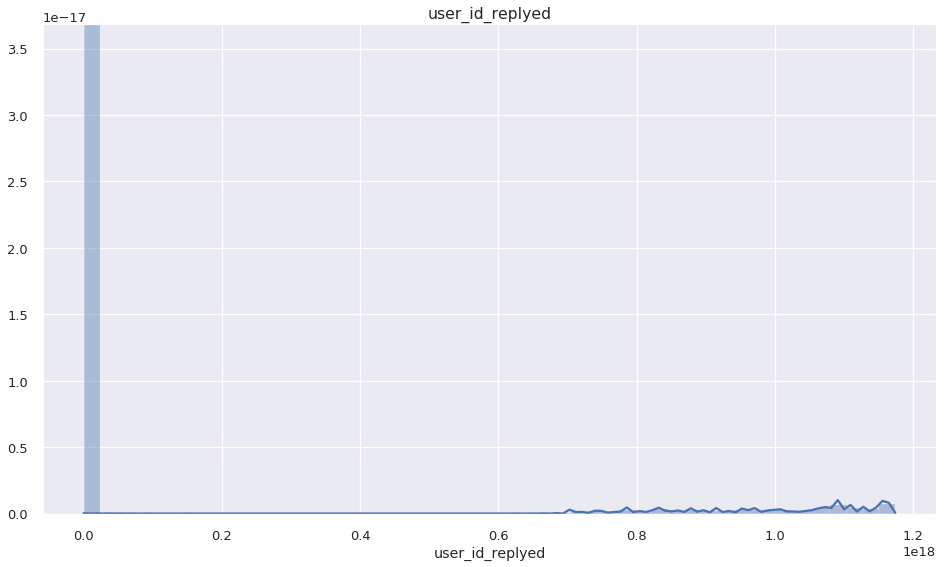

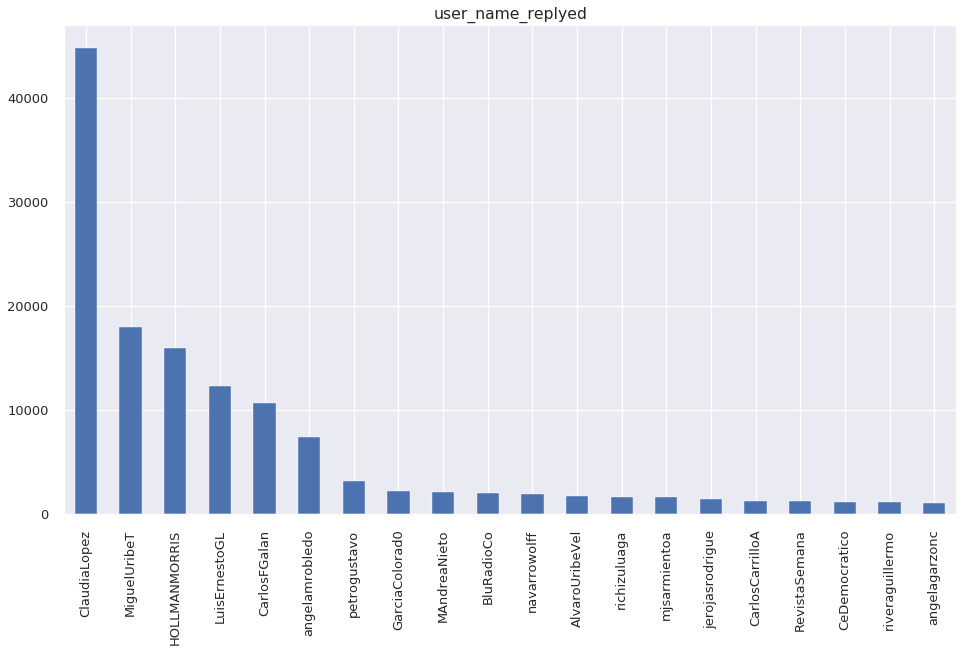

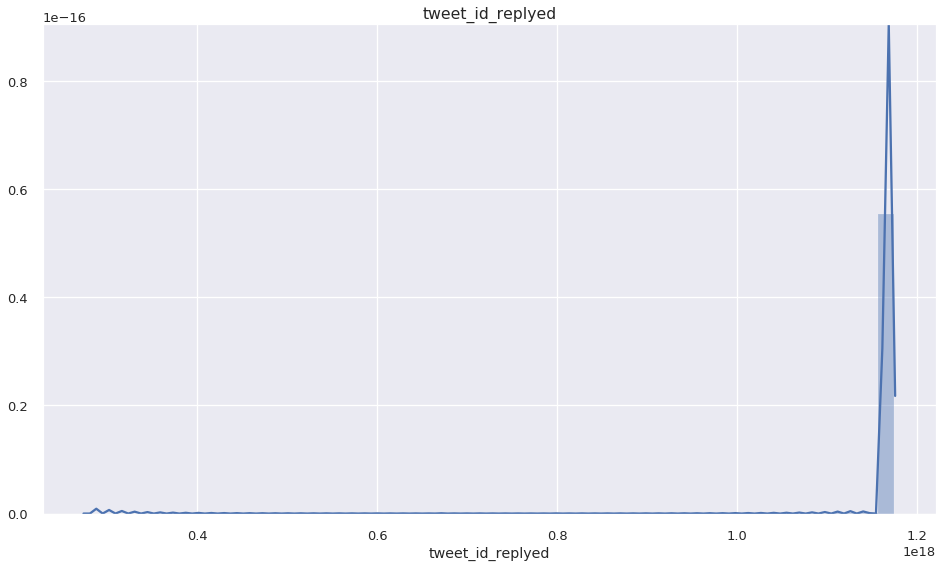

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


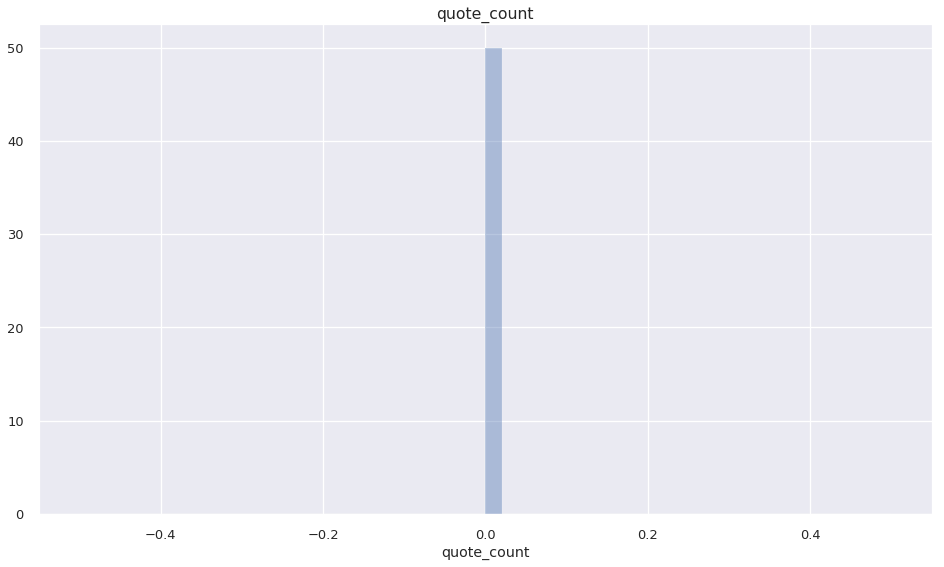

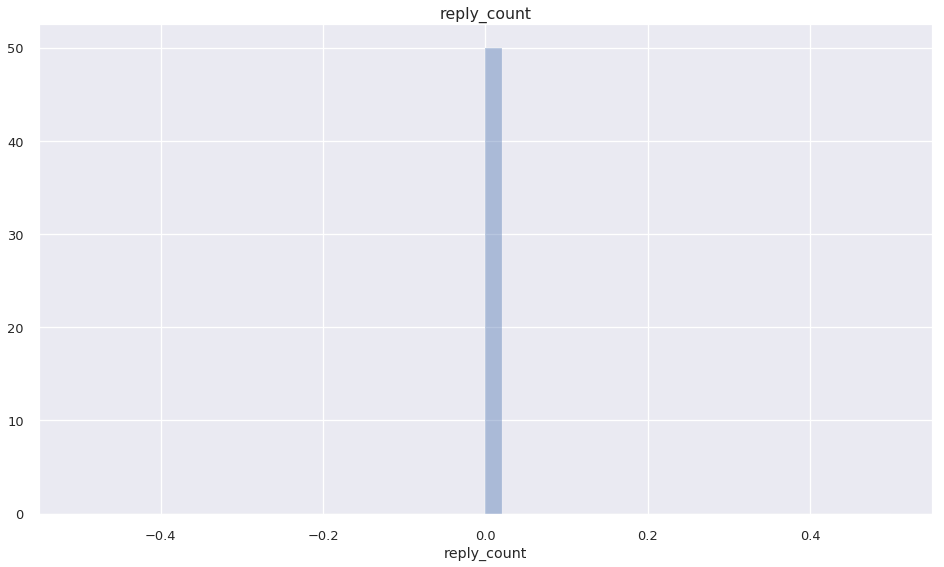

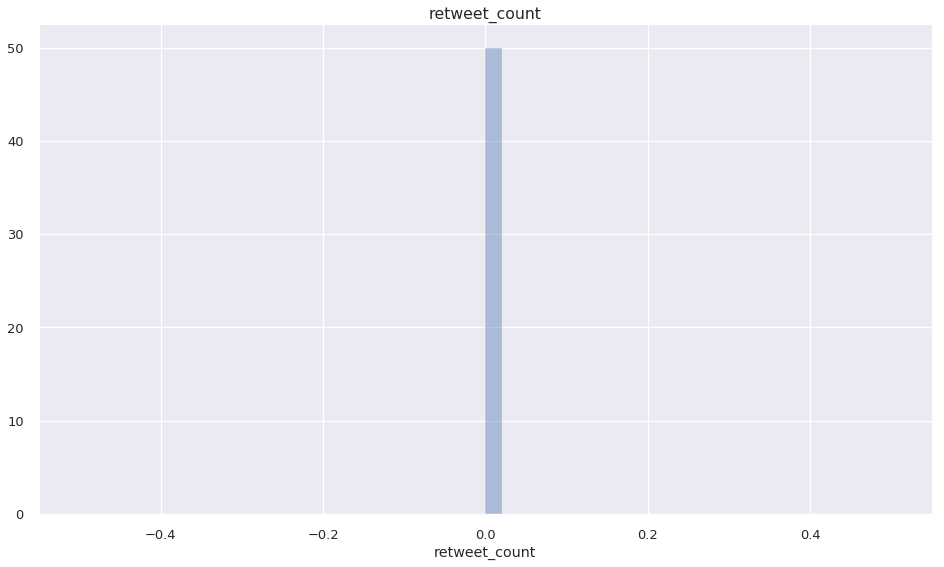

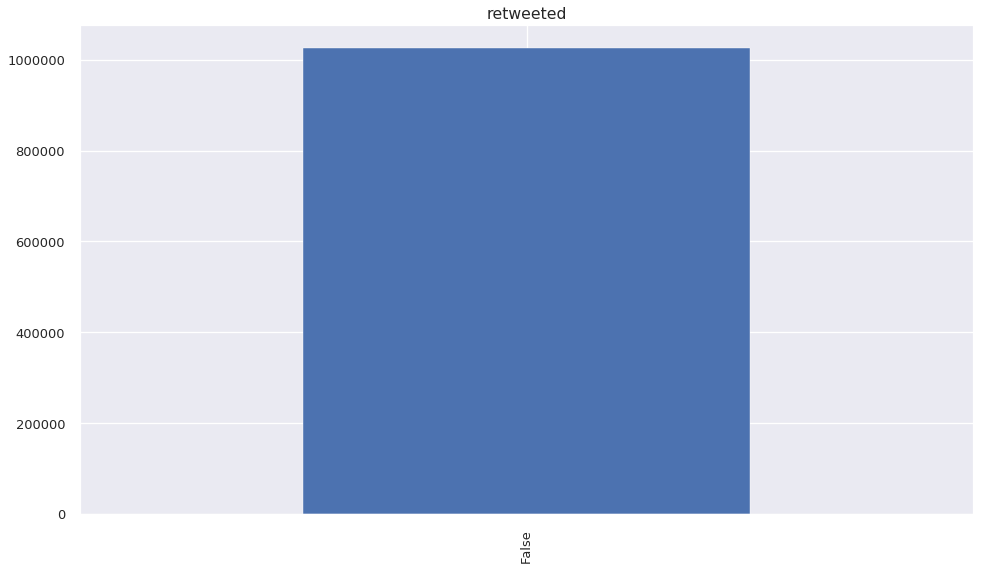

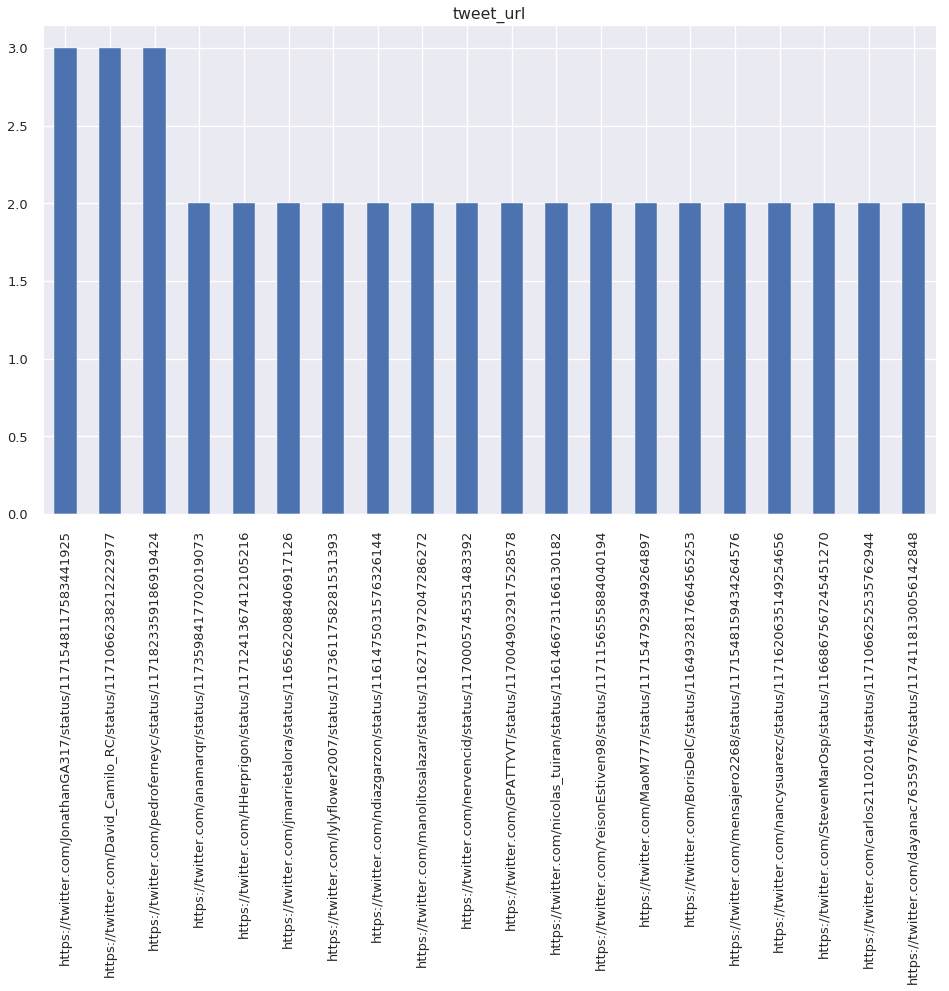

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [0]:
[plot_uni_var(data,column) for column in list(data.columns)]

## Explorar fechas

In [0]:
tw_fechas_df=pd.DataFrame(data[["user_name","date_tweet"]])
tw_fechas_df.columns=["user","date_tweet"]
tw_fechas_df["date_tweet"]=pd.to_datetime(tw_fechas_df['date_tweet'], utc=True)#.tz_convert('US/Eastern')
tw_fechas_df.set_index('date_tweet', inplace=True)#.tz_convert('US/Eastern')
tw_fechas_df.index=tw_fechas_df.index.tz_convert('Etc/GMT+5')
tw_fechas_df["ocurr"]=1

In [0]:
time_sample="3600s"#'1440T'#"900S"#"1800S"#

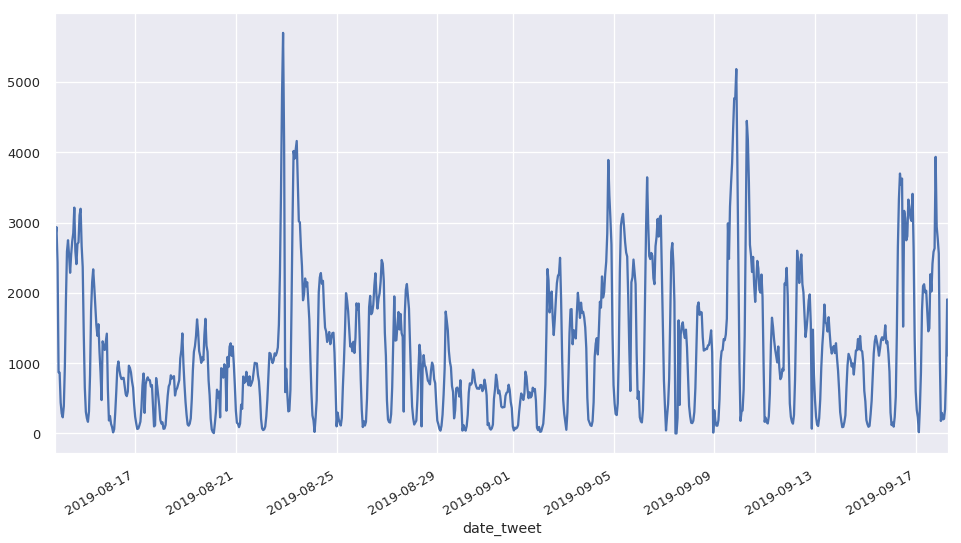

In [0]:
plt.figure(figsize=(16,9))
tw_fechas_df.ocurr.resample(time_sample).sum().plot()#kind="bar")

# Preprocesamiento de texto
procesar con [expresiones regulares](https://medium.com/factory-mind/regex-tutorial-a-simple-cheatsheet-by-examples-649dc1c3f285)

Técnicas de [preprocesamiento de tuits](https://github.com/Deffro/text-preprocessing-techniques) CITAR!!!

In [0]:
corpus=np.array([process(twit) for twit in data.tw_text])
# corpus=corpus[np.random.randint(len(corpus),size=500)]
# tokens=np.array([nltk.word_tokenize(twit) for twit in corpus])


In [0]:
count_vect_full = CountVectorizer()#analyzer=process) 
tf_matrix_full = count_vect_full.fit_transform(corpus)
tf_matrix = tf_matrix_full.astype("int16")
print('{} tweets con {} palabras'.format(tf_matrix_full.shape[0], tf_matrix_full.shape[1]))
print("Tamaño total del corpus:",str(tf_matrix_full.sum()),"términos (sin elminar stopwords)")
#print(count_vect_full.get_feature_names())

1026050 tweets con 141483 palabras
Tamaño total del corpus: 27076673 términos (sin elminar stopwords)


In [0]:
terms_full=count_vect_full.get_feature_names()
words_counts_full=np.zeros(tf_matrix_full[0].toarray().shape).astype(tf_matrix_full[0].toarray().dtype)
for ith_tw in tf_matrix_full:
  words_counts_full=words_counts_full+np.nan_to_num(ith_tw.toarray())

In [0]:
frequencies_full=pd.DataFrame(words_counts_full, columns=terms_full, index=["frequencies"]).T
freq_pos=pd.DataFrame({"pos":np.arange(len(frequencies_full.frequencies)),
                       "freq":np.array(frequencies_full.frequencies.sort_values(ascending=False))}, 
                      index=count_vect_full.get_feature_names())
freq_pos["fr_relat_acum"]=freq_pos.freq.cumsum()/freq_pos.freq.sum()

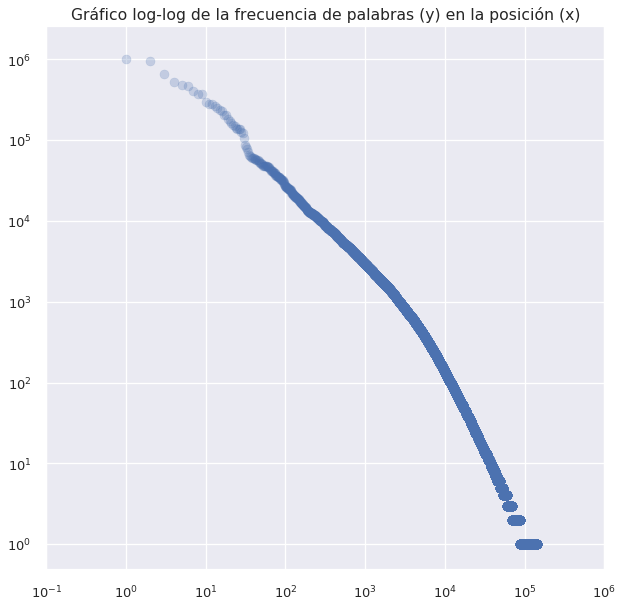

In [0]:
plt.figure(figsize=(10,10))
plt.scatter(x=freq_pos.pos,
            y=freq_pos.freq,
            alpha=.25)
plt.yscale("log")
plt.xscale("log")
plt.xlim(10e-2,10e5) 
plt.title("Gráfico log-log de la frecuencia de palabras (y) en la posición (x)")
plt.show()


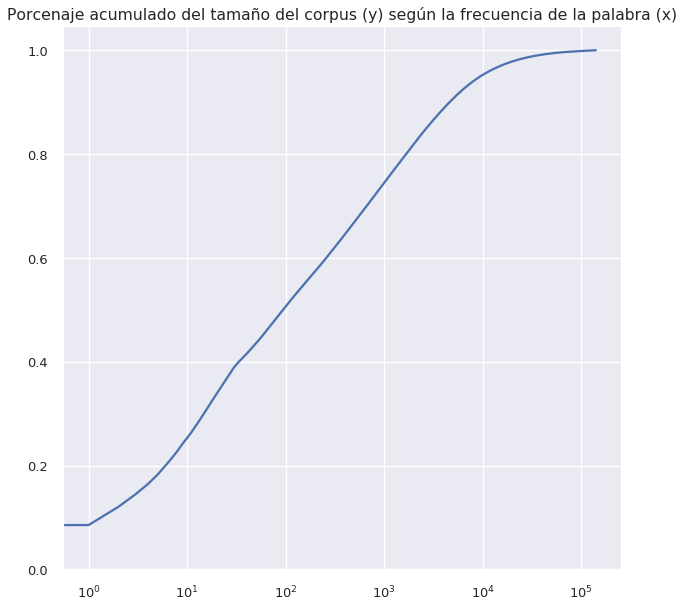

In [0]:
plt.figure(figsize=(10,10))
plt.plot(np.array(freq_pos.fr_relat_acum))
plt.xscale("log")
plt.title("Porcenaje acumulado del tamaño del corpus (y) según la frecuencia de la palabra (x)")
plt.show()

## Eliminar palabras poco informativas

* [pronombres](https://www.solosequenosenada.com/gramatica/spanish/listado/lista_07_pronombres.php)
* [artículos](https://www.practicaespanol.com/los-articulos-en-espanol/)
* [preposiciones](https://www.metro.pr/pr/blogs/2013/06/16/nuevas-preposiciones-espanol-durante-mediante-versus-via.html)

In [0]:
prep_art=["a","en","de","so", "ante","bajo","cabe","con","contra","desde","durante",# Preposiciones
                  "entre","hacia","hasta","mediante","para","por","según","sin","sobre","tras","versus","vía"
                  "el",'la',"los","las","un","una","unos","unas","lo","al","del",# Artículos
#                   "adonde","algo","alguien","alguna","algunas","alguno","algunos","aquel","aquel","aquella",#Pronombres
#                   "aquella","aquellas","aquellas","aquello","aquellos","aquellos","como","como","conmigo","consigo",
#                   "contigo","cual","cual","cuales","cuales","cualesquiera","cualquiera","cuando","cuando","cuanta",
#                   "cuanta","cuantas","cuantas","cuanto","cuantos","cuantos","cuya","cuyas","cuyo","cuyos","demas",
#                   "donde","donde","el","ella","ellas","ello","ellos","esa","esa","esas","esas","ese","ese","eso",
#                   "esos","esos","esotra","esotro","esta","esta","esta","estas","estas","este","este","esto","estos",
#                   "estos","estotra","estotro","la","las","le","les","lo","lo","los","me","mi","mia","mias","mio","mios",
#                   "misma","mismas","mismo","mismos","mucha","muchas","mucho","muchos","nada","nadie","ninguna","ningunas",
#                   "ninguno","ningunos","nos","nosotras","nosotros","nuestra","nuestras","nuestro","nuestros","os","otra",
#                   "otras","otro","otros","poca","pocas","poco","pocos","que","que","quien","quien","quienes","quienes",
#                   "quienesquiera","quienquier","quienquiera","se","si","suya","suyas","suyo","suyos","tanta","tantas","tanto",
#                   "tantos","te","ti","toda","todas","todo","todos","tu","tuya","tuyas","tuyo","tuyos","ultima","ultimas","ultimo",
#                   "ultimos","una","unas","uno","unos","usted","ustedes","varias","varios","vos","vosotras","vosotros","vuestra",
#                   "vuestras","vuestro","vuestros","yo"
                 ]

In [0]:
freq_stop=frequencies_full[np.logical_not(np.isin(frequencies_full.index,np.array(prep_art)))]
freq_val=0
prop_corpus=1.0
while prop_corpus>.75:
  nw_prop=list(freq_stop[freq_stop.frequencies>freq_val+1].sum()/frequencies_full.frequencies.sum())[0]
  if nw_prop>.75:
    prop_corpus=nw_prop
    freq_val+=1
  else:
    break

print("Se pueden eliminar palabras de frecuencia máxima {} y mantener el tamaño del corpus por encima del 75%.".format(freq_val))

Se pueden eliminar palabras de frecuencia máxima 137 y mantener el tamaño del corpus por encima del 75%.


In [0]:
custom_stpowords=list(frequencies_full[frequencies_full.frequencies<=freq_val].index)
custom_stpowords.extend(prep_art)

## Corpus procesado

In [0]:
count_vect = CountVectorizer(stop_words=custom_stpowords)#analyzer=process) 
tf_matrix = count_vect.fit_transform(corpus)
tf_matrix = tf_matrix.astype("int32")
print('{} tweets con {} palabras'.format(tf_matrix.shape[0], tf_matrix.shape[1]))
print("Tamaño total del corpus:",str(tf_matrix.sum()),"términos","\n")

print(str(tf_matrix.sum()/tf_matrix_full.sum()),"Proporción del corpus sin artículos, sin preposiciones, ni palabras de baja frecuencia")


1026050 tweets con 9908 palabras
Tamaño total del corpus: 20313038 términos 

0.7502043548703343 Proporción del corpus sin artículos, sin preposiciones, ni palabras de baja frecuencia


In [0]:
terms=count_vect.get_feature_names()
words_counts=np.zeros(tf_matrix[0].toarray().shape).astype(tf_matrix[0].toarray().dtype)
for ith_tw in tf_matrix:
  words_counts=words_counts+np.nan_to_num(ith_tw.toarray())
frequencies=pd.DataFrame(words_counts, columns=terms, index=["frequencies"]).T

### Los 50 términos más frecuentes

In [0]:
frequencies.sort_values(by="frequencies", ascending=False)[:50]

,frequencies
que,946742
el,662295
no,485661
claudialopez,463438
es,405713
migueluribet,281198
se,280952
hollmanmorris,264357
bogota,237538
su,173640


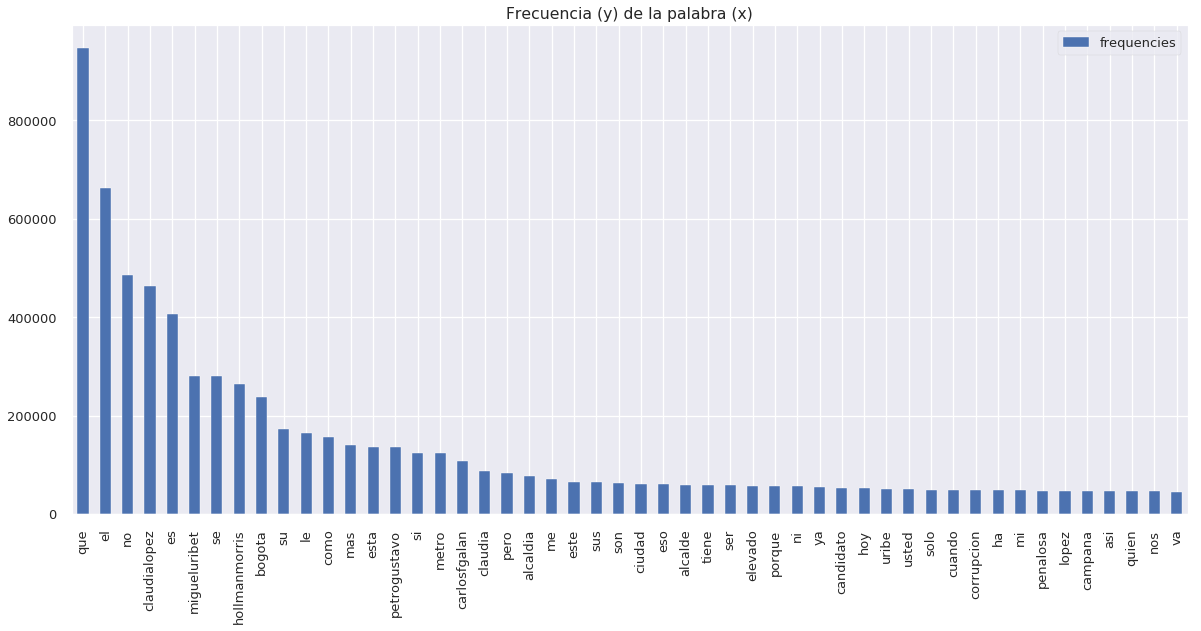

In [0]:
frequencies.sort_values(by="frequencies", ascending=False)[:50].plot(kind="bar",figsize=(20,9))
plt.title("Frecuencia (y) de la palabra (x)")
plt.show()

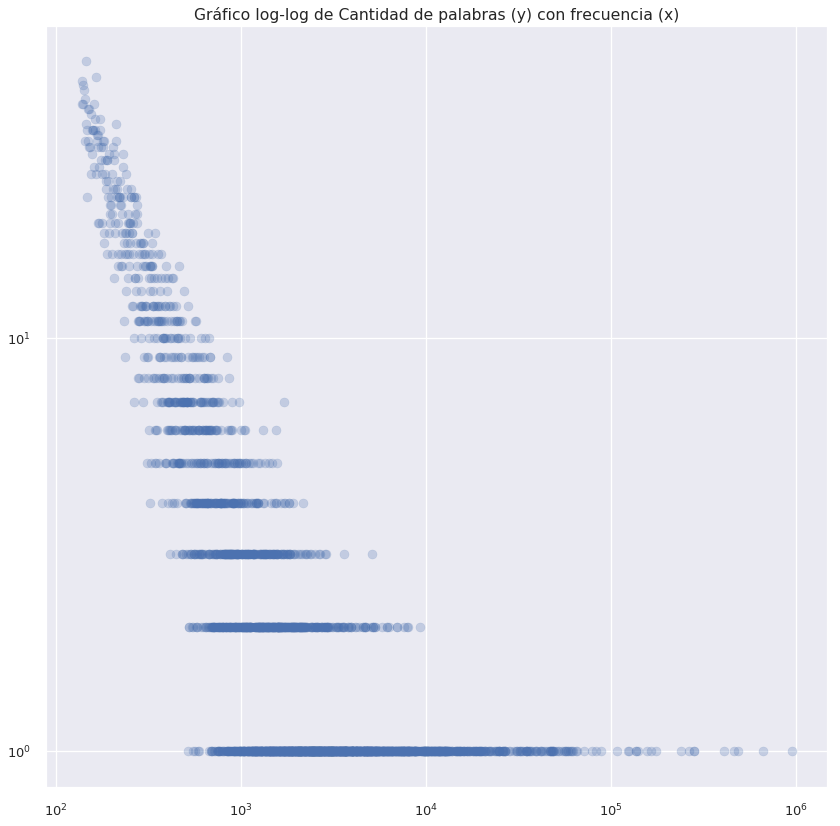

In [0]:
counts_freqs=pd.crosstab(frequencies.frequencies, columns="count")
plt.figure(figsize=(14,14))
plt.scatter(counts_freqs.index,counts_freqs, alpha=.25)#[:1000])
plt.yscale("log")
plt.xscale("log")
plt.title("Gráfico log-log de Cantidad de palabras (y) con frecuencia (x)")
plt.show()

# Checkpoint

## Cargar menciones a candidatos

In [0]:
cands_ments=pd.read_csv(drive_path+"cands_mentions.csv",names=cuentas, index_col=0)

In [0]:
print(cands_ments.shape)
cands_ments.sample(20)

(1026050, 11)


,ClaudiaLopez,carlosfgalan,angelamrobledo,MiguelUribeT,angelagarzonc,luchogarzon,hollmanmorris,MAndreaNieto,CelioNievesH,jerojasrodrigue,LuisErnestoGL
1164587373289717760,True,False,False,False,False,False,False,False,False,False,False
1173056211849240576,False,False,False,False,False,False,False,False,False,False,False
1170318424800669696,False,False,False,True,False,False,False,False,False,False,False
1173051916370227200,True,False,False,False,False,False,False,False,False,False,False
1167501703203217408,False,False,False,True,False,False,False,False,False,False,False
1163135193319976961,False,False,False,False,False,False,True,False,False,False,False
1162181661041352704,True,False,False,False,False,False,False,False,False,False,False
1172503865406763008,True,False,False,True,False,False,False,False,False,False,False
1171417068383678465,False,False,False,False,False,False,True,False,False,False,False
1169634324884480000,True,False,False,False,False,False,False,False,False,False,False


In [0]:
cands_ments.describe()

,ClaudiaLopez,carlosfgalan,angelamrobledo,MiguelUribeT,angelagarzonc,luchogarzon,hollmanmorris,MAndreaNieto,CelioNievesH,jerojasrodrigue,LuisErnestoGL
count,1026050,1026050,1026050,1026050,1026050,1026050,1026050,1026050,1026050,1026050,1026050
unique,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False
freq,585412,920660,990716,744752,1021621,1024490,774641,1015429,1018808,1018036,992829


### Project Variables:
    is_quote_status
    is_reply
    is_retweet
    user_verified
    user_favourites_count
    user_followers_count
    tw_text

In [0]:
variables_CA=pd.concat([data[["is_quote_status",
                              "is_reply",
                              "is_retweet",
                              "user_verified",
                              "user_favourites_count",
                              "user_followers_count"]],
                        cands_ments], axis=1, sort=False)

In [0]:
variables_CA.sample(20)

,is_quote_status,is_reply,is_retweet,user_verified,user_favourites_count,user_followers_count,ClaudiaLopez,carlosfgalan,angelamrobledo,MiguelUribeT,angelagarzonc,luchogarzon,hollmanmorris,MAndreaNieto,CelioNievesH,jerojasrodrigue,LuisErnestoGL
1171393535502950400,True,False,True,False,19622,1653,False,False,False,False,False,False,True,False,False,False,False
1170707194100310017,False,False,True,False,299423,8581,False,False,False,False,False,False,True,False,False,False,False
1171930096007094272,False,False,True,False,259891,12471,False,False,False,True,False,False,False,False,False,False,False
1161602145520693248,True,False,True,False,63987,1101,True,False,False,False,False,False,False,False,False,False,False
1169428683205033984,False,False,True,False,1305,133,False,False,False,True,False,False,False,False,False,False,False
1169974563586940929,True,False,False,False,598,198,False,False,False,False,False,False,False,False,False,False,False
1170343855075549189,True,False,True,False,10621,107,False,False,False,False,False,False,True,False,False,False,False
1166050483473137664,False,False,False,False,496,1092,False,False,False,False,False,False,False,False,False,False,False
1164288316621164551,False,False,True,False,3049,72,False,False,False,True,False,False,False,False,False,False,False
1169669803117879297,False,True,False,False,2337,224,False,False,False,True,False,False,False,False,False,False,False


##Grabar:
* vectorizador 
* matriz tf de corpus procesado
* VAriables de interés FA

In [0]:
output = open(drive_path+'processed_data.pkl', 'wb')
pickle.dump([count_vect,tf_matrix,variables_CA], output)# Pickle dictionary using protocol 0.
output.close()

### data sample y matriz de ocurrencias

In [0]:
data.to_csv(drive_path+'data_sample.csv')

In [0]:
# fr_mat=pd.DataFrame(tf_matrix.toarray(), columns=terms, index=data.tweet_id)
# fr_mat.to_csv(drive_path+'fr_mat_sample.csv')

##Cargar vectorizador y matriz tf de corpus procesado

In [0]:
pkl_file = open(drive_path+'processed_data.pkl', 'rb')
count_vect,tf_matrix, variables_CA = pickle.load(pkl_file)
pkl_file.close()
tf_matrix

<1026050x9908 sparse matrix of type '<class 'numpy.int32'>'
	with 18712567 stored elements in Compressed Sparse Row format>

In [0]:
variables_CA.shape

(1026050, 17)

In [0]:
# data=pd.read_csv(drive_path+'data_sample.csv', index_col=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,5,9,11,13,14,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
print(data.shape)

(1026050, 22)


In [0]:
print(len(set(data.index)))
print(len(set(variables_CA.index)))
# data=data.loc[variables_CA.index,:]

1025782
1025782


# Tabla de Contingencia Léxica


## Muestra de datos

In [0]:
# sample_size=100000
# sample_indx=np.random.randint(0,data.shape[0],sample_size)
# data_sample=data.iloc[sample_indx,:]
# data_sample.shape
data_sample=data#.loc[variables_CA.index,:]#data

In [0]:
data.columns

Index(['date_tweet', 'user_id', 'user_name', 'user_location', 'user_verified',
       'user_followers_count', 'user_friends_count', 'user_favourites_count',
       'user_statuses_count', 'user_created_at', 'is_retweet', 'tw_text',
       'is_quote_status', 'is_reply', 'user_id_replyed', 'user_name_replyed',
       'tweet_id_replyed', 'quote_count', 'reply_count', 'retweet_count',
       'retweeted', 'tweet_url'],
      dtype='object')

In [0]:
corpus_sample=np.array([process(twit) for twit in data_sample.tw_text])
tf_matrix_sample = count_vect.fit_transform(corpus_sample)

In [0]:
variables_sample=variables_CA#.iloc[sample_indx,:]
variables_sample=variables_sample.loc[:,['is_quote_status',
                                         'is_reply', 
                                         'is_retweet', 
                                         'user_verified',
                                         'ClaudiaLopez',
                                         'carlosfgalan', 
                                         'MiguelUribeT', 
                                         'hollmanmorris'
                                        ]]
variables_sample.shape

(1026050, 8)

In [0]:
print(variables_sample.shape)
print(tf_matrix_sample.shape)
print(len(count_vect.get_feature_names()))

(1026050, 8)
(1026050, 9908)
9908


In [0]:
lexic_df_sample=tabl_cont_lex(variables_sample,
                              tf_matrix_sample,
                              count_vect.get_feature_names())

In [0]:
print(lexic_df_sample.shape)
lexic_df_sample.sample(50)

(9908, 16)


,is_quote_status_False,is_quote_status_True,is_reply_False,is_reply_True,is_retweet_False,is_retweet_True,user_verified_False,user_verified_True,ClaudiaLopez_False,ClaudiaLopez_True,carlosfgalan_False,carlosfgalan_True,MiguelUribeT_False,MiguelUribeT_True,hollmanmorris_False,hollmanmorris_True
afectara,208,3,183,28,33,178,211,0,21,190,211,0,209,2,198,13
palma,346,42,357,31,36,352,387,1,178,210,383,5,263,125,378,10
anani0,457,2,201,258,258,201,459,0,372,87,459,0,459,0,274,185
construimos,253,36,265,24,35,254,283,6,176,113,284,5,173,116,249,40
2400,192,18,140,70,87,123,210,0,33,177,208,2,187,23,205,5
vemos,1458,241,1351,348,475,1224,1649,50,719,980,1593,106,1537,162,1007,692
precario,198,3,184,17,19,182,200,1,4,197,199,2,197,4,198,3
chavismo,180,11,96,95,106,85,191,0,118,73,185,6,162,29,126,65
acomodar,61,449,474,36,42,468,509,1,477,33,507,3,488,22,54,456
verse,118,43,94,67,81,80,161,0,80,81,158,3,143,18,140,21


In [0]:
lexic_df_sample.to_csv(drive_path+'lexical_contingency_table_sample.csv')

In [0]:
lexic_df=pd.read_csv(drive_path+'lexical_contingency_table_sample.csv', index_col=0)

In [0]:
lexic_df.sample(20)

,is_quote_status_False,is_quote_status_True,is_reply_False,is_reply_True,is_retweet_False,is_retweet_True,user_verified_False,user_verified_True,ClaudiaLopez_False,ClaudiaLopez_True,carlosfgalan_False,carlosfgalan_True,MiguelUribeT_False,MiguelUribeT_True,hollmanmorris_False,hollmanmorris_True
noalpactodesilencio,160,0,160,0,1,159,159,1,160,0,160,0,160,0,0,160
elcambioesimparable,115,278,374,19,45,348,385,8,28,365,389,4,386,7,389,4
onda,63,155,170,48,53,165,214,4,22,196,204,14,208,10,210,8
importar,358,138,262,234,267,229,492,4,299,197,424,72,390,106,377,119
polarizar,267,49,183,133,160,156,314,2,143,173,240,76,304,12,252,64
viaducto,370,16,289,97,100,286,384,2,77,309,371,15,349,37,330,56
movimiento,1595,478,1488,585,760,1313,2040,33,1592,481,1684,389,1806,267,1740,333
aprobo,643,194,640,197,214,623,831,6,435,402,830,7,558,279,756,81
cambiado,270,16,129,157,175,111,285,1,103,183,256,30,271,15,248,38
sandeces,175,13,107,81,93,95,187,1,81,107,183,5,153,35,162,26


# Análisis de correspondencias

In [0]:
YouTubeVideo('62N0JMf5hOs', width=600, height=400)

**texto en negrita**## Código en R

### Corresp Analysis FactoMineR
[Ejemplo en R](https://www.youtube.com/watch?v=62N0JMf5hOs)
```
#install.packages("FactoMineR", repos="https://cloud.r-project.org/")
library(FactoMineR)

#?CA
ca2 = CA(lex_cont_tbl, graph = FALSE)
#plot(ca2)


plot(ca2,
	shadowtext=TRUE,
	unselect=.95,
	cex=.8,
	selectRow="contrib 25"
	)

summary(ca2)

summary(ca2, nbelements=Inf, file="out_CA.txt")


desc_tab=dimdesc(ca2)
```

